## This is an implementation based on the Homework

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from gymnasium.wrappers import TimeLimit, NormalizeObservation, NormalizeReward
from stable_baselines3.common.vec_env import SubprocVecEnv

In [ ]:
class WalkerRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        
        # Extract the forward velocity (typically part of the info dictionary)
        velocity = info.get("x_velocity", 0)  # Default to 0 if key not found
        
        # Modify the reward: double the forward reward component
        new_reward = reward + velocity  # Since original reward includes velocity, we add again
        
        return obs, new_reward, done, truncated, info

# Create the wrapped environment
env = gym.make("Walker2d-v5")
env = WalkerRewardWrapper(env)

# Now, when you step through the environment, it will use the modified reward function.
obs = env.reset()

In [3]:
def modify_geometry_parameters(model):
    # Modify link lengths (example: double the length of thigh and leg) MuJoCo uses capsules which is made up of [radius, hal-length]
    model.geom_size[1] = [0.05, 0.2, 0.]  # torso_geom: 
    model.geom_size[2], model.geom_size[5] = [0.05, 0.225, 0.], [0.05, 0.225, 0.]  # thigh_geom, thigh_left_geom : [radius, hal-length, 0.]
    model.geom_size[3], model.geom_size[6] = [0.04, 0.25, 0.], [0.04, 0.25, 0.]  # leg_geom, leg_left_geom: [radius, hal-length, 0.]
    model.geom_size[4], model.geom_size[7] = [0.06, 0.05, 0.], [0.06, 0.05, 0.]  # foot_geom, foot_left_geom: [radius, hal-length, 0.]

Walker2d requires a Gaussian policy with learned mean and variance.

Walker2d: 17D observation space, continuous 6D action space (Gaussian distribution).

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
env = gym.make("Walker2d-v5")
env = NormalizeObservation(env)  # Normalize observations to mean 0, std 1
env = NormalizeReward(env)  # Normalize rewards
model = env.unwrapped.model # Access the MuJoCo model
# modify_geometry_parameters(model)
obs_dim = env.observation_space.shape[0]  # 17
act_dim = env.action_space.shape[0]  # 6

class ActorNet(nn.Module):
    def __init__(self, input_dim=obs_dim, output_dim=act_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, output_dim)
        self.log_std = nn.Parameter(torch.zeros(output_dim))  # Learnable log std

    def forward(self, s):
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.mu(x))  # Actions in range (-1,1)
        std = torch.exp(self.log_std)  # Convert log_std to std
        return mu, std

class ValueNet(nn.Module):
    def __init__(self, input_dim=obs_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        return self.output(x)

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

Using device: cpu


## FAST LEARN

In [ ]:
gamma = 0.99
tau = 0.95  # GAE smoothing
clip_epsilon = 0.1
# These coefficients are experimentally determined in practice.
vf_coeff = 0.5  # weight coefficient for KL-divergence loss
kl_coeff = 0.2  # weight coefficient for value loss
lr = 1e-3

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)
optimizer = optim.Adam(list(actor_func.parameters()) + list(value_func.parameters()), lr=lr)
    
# Compute Generalized Advantage Estimation (GAE)
def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    deltas = []
    for t in range(len(rewards)):  # Iterate over all rewards
        delta = rewards[t] + gamma * (values[t + 1] if t + 1 < len(values) else 0) - values[t] # Calculate the TD error (delta)
        deltas.append(delta)
    advantages = []
    adv = 0
    for delta in reversed(deltas):
        adv = delta + gamma * tau * adv
        advantages.insert(0, adv)
    return advantages

# Sampling function
def pick_sample_and_logp(s):
    with torch.no_grad():
        s = torch.tensor(s, dtype=torch.float, device=device).unsqueeze(0)
        mu, std = actor_func(s)
        dist = torch.distributions.Normal(mu, std)  # Used to sample continuous actions.
        action = dist.sample()
        action = torch.clamp(action, min=-1.0, max=1.0)
        # print(f"Sampled action: {action}")
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action.squeeze(0).cpu().numpy(), log_prob.cpu().numpy()

reward_records = []
for episode in range(100):
    done = False
    step_count = 0
    states, actions, log_probs, rewards = [], [], [], []
    s, _ = env.reset()
    
    while not done:
        states.append(s)
        a, logp = pick_sample_and_logp(s)
        s, r, term, trunc, info = env.step(a)
        # if "reward_forward" in info and "reward_ctrl" in info:
        #     print(f"Forward Reward: {info['reward_forward']}, Control Cost: {info['reward_ctrl']}")
        done = term or trunc
        actions.append(a)
        log_probs.append(logp)
        rewards.append(r)
        step_count += 1  # Increment step counter

    rewards = np.array(rewards)
    states = np.array(states)
    actions = np.array(actions)
    log_probs = np.array(log_probs)
    states = torch.tensor(states, dtype=torch.float, device=device)
    actions = torch.tensor(actions, dtype=torch.float, device=device)
    log_probs = torch.tensor(log_probs, dtype=torch.float, device=device)
    log_probs = log_probs.squeeze(dim=-1)  

    values = value_func(states).squeeze()
    advantages = compute_gae(rewards, values.detach().cpu().numpy())
    advantages = torch.tensor(advantages, dtype=torch.float, device=device)

    # Compute PPO loss
    mu, std = actor_func(states)
    dist = torch.distributions.Normal(mu, std)
    new_log_probs = dist.log_prob(actions).sum(dim=-1)

    # print("new_log_probs shape:", new_log_probs.shape)
    # print("log_probs shape:", log_probs.shape)
    ratio = torch.exp(new_log_probs - log_probs)
    # print("ratio shape:", ratio.shape)
    # print("advantages shape:", advantages.shape)
    surrogate = ratio * advantages
    clipped_surrogate = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    policy_loss = -torch.min(surrogate, clipped_surrogate).mean()

    returns = advantages + values
    value_loss = F.mse_loss(value_func(states).squeeze(), returns.detach())
    
    loss = policy_loss + vf_coeff * value_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_reward = np.sum(rewards)
    reward_records.append(total_reward)

    print(f"Episode {episode}, Steps: {step_count}, Reward: {total_reward}", end="\r")

    if np.mean(reward_records[-50:]) > 4000:  # Stop condition for MuJoCo
        break

print("\nDone")
env.close()

# # Hyperparameters
# hyperparameters = {
#     'Episodes': 40000,
#     'gamma': 0.99,
#     'tau': 0.95,
#     'clip_epsilon': 0.1,
#     'vf_coeff': 0.5,
#     'kl_coeff': 0.2,
#     'lr': 1e-3,
#     'actor_hidden_size': 64,  # Example hidden size
#     'value_hidden_size': 64,  # Example hidden size
#     'max_grad_norm': 0.5,     # Optional, if you're using gradient clipping
# }

# # Create a string to save as a text file
# hyperparameters_str = '\n'.join([f'{key}: {value}' for key, value in hyperparameters.items()])

# # Save the hyperparameters to a text file
# with open("hyperparameters_FastLearn40K.txt", "w") as f:
#     f.write("Hyperparameters used during training:\n")
#     f.write(hyperparameters_str)

# print("Hyperparameters saved to 'hyperparameters_FastLearn40K.txt'")

torch.save(actor_func.state_dict(), "PPO_runs/ppo_walker2d_rewardtest.pth")



Forward Reward: -0.36753320255560734, Control Cost: -0.0020291663240641356
Forward Reward: -0.7392582810625038, Control Cost: -0.0023200560826808214
Forward Reward: -0.35769254460303945, Control Cost: -0.00461614690721035
Forward Reward: 0.07815546630057182, Control Cost: -0.002199856098741293
Forward Reward: -0.05985510775266111, Control Cost: -0.0016573094762861729
Forward Reward: 0.05109026995629641, Control Cost: -0.0030360938981175423
Forward Reward: -0.051195986350528785, Control Cost: -0.0010686091845855117
Forward Reward: -0.2203384457042368, Control Cost: -0.0021077462006360292
Forward Reward: -0.08487864730725145, Control Cost: -0.0012076955754309893
Forward Reward: -0.04214010181758602, Control Cost: -0.0030902144499123096
Forward Reward: -0.29985197446031503, Control Cost: -0.002886303002014756
Forward Reward: -0.6751797279378651, Control Cost: -0.004110678564757109
Forward Reward: -0.6505563753710849, Control Cost: -0.0015632512513548136
Forward Reward: -0.3739241683301678

## STABLE LEARN with 4 environments


In [16]:
gamma = 0.99
tau = 0.95  # GAE smoothing
clip_epsilon = 0.2
# These coefficients are experimentally determined in practice.
vf_coeff = 0.5  # weight coefficient for KL-divergence loss
kl_coeff = 0.2  # weight coefficient for value loss
lr = 3e-4

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)
optimizer = optim.Adam(list(actor_func.parameters()) + list(value_func.parameters()), lr=lr)
    
# Compute Generalized Advantage Estimation (GAE)
def compute_gae(rewards, values, masks, gamma=0.99, tau=0.95):
    """
    Compute GAE for multiple environments.
    rewards: list of rewards for each environment
    values: list of value predictions
    masks: list of done masks (1 if not done, 0 if done)
    """
    T = len(rewards[0])  # Number of steps
    N = len(rewards)     # Number of environments
    advantages = [[] for _ in range(N)]
    
    for env_idx in range(N):
        deltas = []
        for t in range(T):
            delta = (rewards[env_idx][t] + gamma * values[env_idx][t + 1] * masks[env_idx][t + 1] 
                     if t + 1 < T else 0) - values[env_idx][t]
            deltas.append(delta)
        
        adv = 0
        for delta in reversed(deltas):
            adv = delta + gamma * tau * adv
            advantages[env_idx].insert(0, adv)
    
    return [torch.tensor(advs, dtype=torch.float, device=device) for advs in advantages]

# Sampling function
def pick_sample_and_logp(states):
    with torch.no_grad():
        states = torch.tensor(states, dtype=torch.float, device=device)#.unsqueeze(0)
        mu, std = actor_func(states)
        dist = torch.distributions.Normal(mu, std)  # Used to sample continuous actions.
        actions = dist.sample()
        actions = torch.clamp(actions, min=-1.0, max=1.0)
        # print(f"Sampled action: {action}")
        log_probs = dist.log_prob(actions).sum(dim=-1)
        return actions.cpu().numpy(), log_probs.cpu().numpy()
    
# Create 4 environments
num_envs = 4
envs = [gym.make('Walker2d-v5') for _ in range(num_envs)]  

reward_records = []
for episode in range(1000):
    # Reset all environments
    states = [env.reset()[0] for env in envs]  # Initial states
    done = [False] * num_envs
    step_count = 0

    all_states, all_actions, all_log_probs, all_rewards, all_masks = [], [], [], [], []
    
    # Run for a fixed number of steps or until all environments are done
    max_steps = 1000  # Adjust as needed
    for t in range(max_steps):
        if all(done):  # If all environments are done, break
            break
            
        # Collect experiences
        current_states = [s for i, s in enumerate(states) if not done[i]]
        if not current_states:
            break
        actions, log_probs = pick_sample_and_logp(current_states)

        # Step in each active environment
        new_states, rewards, terms, truncs, _ = zip(*[envs[i].step(actions[j]) for j, i in enumerate([i for i, d in enumerate(done) if not d])])
        new_states, rewards, terms, truncs = list(new_states), list(rewards), list(terms), list(truncs)

        # Update done flags and states
        for i in range(num_envs):
            if not done[i]:
                idx = [j for j, d in enumerate(done) if not d].index(i)
                states[i] = new_states[idx]
                done[i] = terms[idx] or truncs[idx]
                all_states.append(current_states[idx])
                all_actions.append(actions[idx])
                all_log_probs.append(log_probs[idx])
                all_rewards.append(rewards[idx])
                all_masks.append(0.0 if done[i] else 1.0)

        step_count += sum(1 for d in done if not d)

    # Convert to tensors (assuming all environments have the same observation/action space)
    states_tensor = torch.tensor(all_states, dtype=torch.float, device=device)
    actions_tensor = torch.tensor(all_actions, dtype=torch.float, device=device)
    log_probs_tensor = torch.tensor(all_log_probs, dtype=torch.float, device=device).squeeze(-1)
    rewards_tensor = torch.tensor(all_rewards, dtype=torch.float, device=device)
    masks_tensor = torch.tensor(all_masks, dtype=torch.float, device=device)

    # Compute values
    values = value_func(states_tensor).squeeze()
    values_list = values.detach().cpu().numpy()

    # Compute advantages
    advantages = compute_gae([all_rewards], [values_list], [all_masks])

    # Compute PPO loss (vectorized)
    mu, std = actor_func(states_tensor)
    dist = torch.distributions.Normal(mu, std)
    new_log_probs = dist.log_prob(actions_tensor).sum(dim=-1)

    ratio = torch.exp(new_log_probs - log_probs_tensor)
    surrogate = ratio * advantages[0]
    clipped_surrogate = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages[0]
    policy_loss = -torch.min(surrogate, clipped_surrogate).mean()

    returns = advantages[0] + values
    value_loss = nn.MSELoss()(value_func(states_tensor).squeeze(), returns.detach())
    
    loss = policy_loss + vf_coeff * value_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_reward = sum(all_rewards)
    reward_records.append(total_reward)

    print(f"Episode {episode}, Steps: {step_count}, Total Reward: {total_reward}", end="\r")

    if np.mean(reward_records[-50:]) > 4000:  # Stop condition
        break

print("\nDone")
for env in envs:
    env.close()

# # Hyperparameters
# hyperparameters = {
#     'Episodes': 40000,
#     'gamma': 0.99,
#     'tau': 0.95,
#     'clip_epsilon': 0.3,
#     'vf_coeff': 0.8,
#     'kl_coeff': 0.1,
#     'lr': 1e-5,
#     'actor_hidden_size': 64,  # Example hidden size
#     'value_hidden_size': 64,  # Example hidden size
#     'max_grad_norm': 0.5,     # Optional, if you're using gradient clipping
# }

# # Create a string to save as a text file
# hyperparameters_str = '\n'.join([f'{key}: {value}' for key, value in hyperparameters.items()])

# # Save the hyperparameters to a text file
# with open("hyperparameters_StableLearn40K.txt", "w") as f:
#     f.write("Hyperparameters used during training:\n")
#     f.write(hyperparameters_str)

# print("Hyperparameters saved to 'hyperparameters_StableLearn40K.txt'")

# torch.save(actor_func.state_dict(), "PPO_runs/ppo_walker2d_actor_StableLearn40K_SmallFeet.pth")



Episode 999, Steps: 331, Total Reward: -67.507762493695086
Done


In [ ]:
torch.save(actor_func.state_dict(), "PPO_runs/ppo_walker2d_4envs_test.pth")

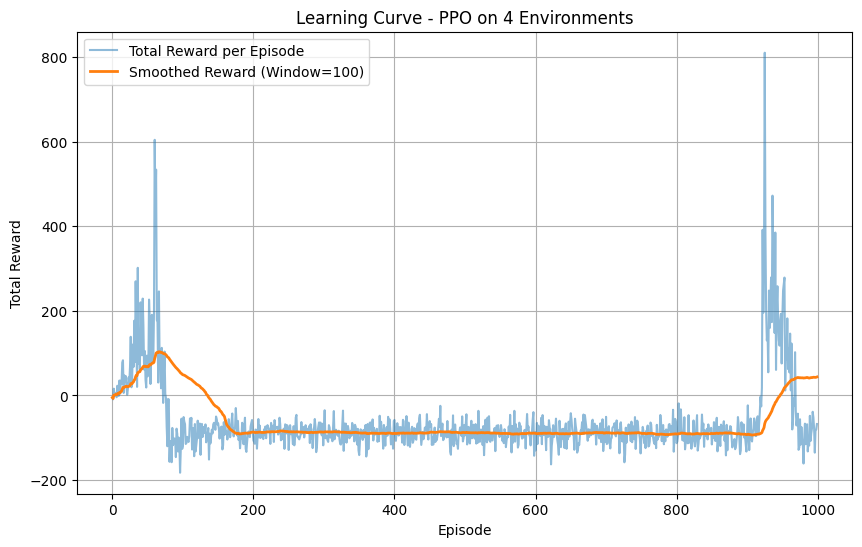

In [17]:
import matplotlib.pyplot as plt
# # Load the critic model (correctly)
# value_func.load_state_dict(torch.load("PPO_runs/ppo_walker2d_critic.pth"))
# value_func.eval()  # Set to evaluation mode

# Assuming reward_records is already collected from your training loop

# Generate recent 100 interval average (smoothed curve)
average_reward = []
window_size = 100  # You can adjust this window size

for idx in range(len(reward_records)):
    if idx < window_size - 1:
        # If we don't have enough data yet, average all rewards so far
        avg = np.mean(reward_records[:idx + 1])
    else:
        # Average over the last window_size episodes
        avg = np.mean(reward_records[idx - window_size + 1:idx + 1])
    average_reward.append(avg)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: set figure size for better visibility
plt.plot(reward_records, label='Total Reward per Episode', alpha=0.5)  # Raw rewards
plt.plot(average_reward, label=f'Smoothed Reward (Window={window_size})', linewidth=2)  # Smoothed rewards

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve - PPO on 4 Environments')
plt.legend()
plt.grid(True)

# # Save the plot
# plt.savefig("PPO_Plots/ppo_walker2d_actor_BalancedLearn40K_SmallFeet.png")
# plt.close()  # Close the figure to free memory

# print("Learning curve plotted and saved to 'PPO_Plots/ppo_walker2d_actor_BalancedLearn40K_SmallFeet.png'")

In [18]:
# actor_func.load_state_dict(torch.load("PPO_runs/ppo_walker2d_actor_BalancedLearn40K_SmallFeet.pth"))
actor_func.eval()  # Set to evaluation mode

def visualize_walker(env_name="Walker2d-v5", episodes=10, render=True):
    env = gym.make(env_name, render_mode="human")  # Enable rendering
    model = env.unwrapped.model # Access the MuJoCo model
    modify_geometry_parameters(model)
    for episode in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                mu, _ = actor_func(obs_tensor)
                action = mu.cpu().numpy().flatten()  # Convert to NumPy

            obs, reward, terminated, truncated, info = env.step(action)
            if "reward_forward" in info and "reward_ctrl" in info:
                print(f"Forward Reward: {info['reward_forward']}, Control Cost: {info['reward_ctrl']}")
           

## BALANCED LEARN

In [ ]:
# Hyperparameters
num_envs = 4  # Number of parallel environments
gamma = 0.99
tau = 0.95  # GAE smoothing
clip_epsilon = 0.2
# These coefficients are experimentally determined in practice.
vf_coeff = 0.5  # weight coefficient for KL-divergence loss
kl_coeff = 0.2  # weight coefficient for value loss
lr = 3e-4

# Function to create parallel environments
def make_env():
    return gym.make("Walker2d-v5")
# Create vectorized environments
envs = SubprocVecEnv([make_env for _ in range(num_envs)])

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)
actor_optimizer = optim.Adam(actor_func.parameters(), lr=lr)
value_optimizer = optim.Adam(value_func.parameters(), lr=lr)
    
# Compute Generalized Advantage Estimation (GAE)
def compute_gae(rewards, values, gamma, tau):
    deltas = []
    for t in range(len(rewards)):  # Iterate over all rewards
        delta = rewards[t] + gamma * (values[t + 1] if t + 1 < len(values) else 0) - values[t] # Calculate the TD error (delta)
        deltas.append(delta)
    advantages = []
    adv = 0
    for delta in reversed(deltas):
        adv = delta + gamma * tau * adv
        advantages.insert(0, adv)
    return advantages

# Sampling function
def pick_sample_and_logp(s):
    with torch.no_grad():
        s = torch.tensor(s, dtype=torch.float, device=device).unsqueeze(0)
        mu, std = actor_func(s)
        dist = torch.distributions.Normal(mu, std)  # Used to sample continuous actions.
        action = dist.sample()
        action = torch.clamp(action, min=-1.0, max=1.0)
        # print(f"Sampled action: {action}")
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action.squeeze(0).cpu().numpy(), log_prob.cpu().numpy()

reward_records = []
obs = envs.reset()

for episode in range(400):
    done = np.array([False] * num_envs)
    step_count = 0
    states, actions, log_probs, rewards = [], [], [], []
    # s, _ = env.reset()
    
    while not np.all(done):
        # Store states
        states.append(obs)
        # Sample actions correctly for parallel environments
        action_batch, logp_batch = zip(*[pick_sample_and_logp(o) for o in obs])
        action_batch = np.array(action_batch)  # Convert to NumPy array
        logp_batch = np.array(logp_batch)

        next_obs, reward, term, trunc = envs.step(action_batch)
        done = np.logical_or(term, trunc)

        # print(f"Step: {step_count}, Actions: {action_batch}, State: {obs}")

        # Store actions and rewards
        obs = next_obs  # Update current observation
        actions.append(action_batch)
        log_probs.append(logp_batch)
        rewards.append(reward)
        step_count += 1  # Increment step counter

    # Convert lists to tensors
    rewards = np.array(rewards, dtype=np.float32)
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.float32)
    log_probs = np.array(log_probs, dtype=np.float32)

    states = torch.tensor(states, dtype=torch.float, device=device)
    actions = torch.tensor(actions, dtype=torch.float, device=device)
    log_probs = torch.tensor(log_probs, dtype=torch.float, device=device).squeeze(dim=-1)

    # Compute value function estimates
    values = value_func(states).squeeze()
    advantages = compute_gae(rewards, values.detach().cpu().numpy(), gamma, tau)
    advantages = torch.tensor(advantages, dtype=torch.float, device=device)

    # Compute PPO loss
    mu, std = actor_func(states)
    dist = torch.distributions.Normal(mu, std)
    new_log_probs = dist.log_prob(actions).sum(dim=-1)

    # print("new_log_probs shape:", new_log_probs.shape)
    # print("log_probs shape:", log_probs.shape)
    ratio = torch.exp(new_log_probs - log_probs)
    # print("ratio shape:", ratio.shape)
    # print("advantages shape:", advantages.shape)
    surrogate = ratio * advantages
    clipped_surrogate = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    policy_loss = -torch.min(surrogate, clipped_surrogate).mean()

    returns = advantages + values
    value_loss = F.mse_loss(value_func(states).squeeze(), returns.detach().squeeze())
    
    # Optimize Policy and Value Networks
    loss = policy_loss + vf_coeff * value_loss
    actor_optimizer.zero_grad()
    value_optimizer.zero_grad()
    loss.backward()
    actor_optimizer.step()
    value_optimizer.step()

    total_reward = np.sum(rewards)
    reward_records.append(total_reward)

    print(f"Episode {episode}, Steps: {step_count}, Reward: {total_reward}, Value Loss: {value_loss.item()}, Policy Loss: {policy_loss.item()}", end="\r")

    if np.mean(reward_records[-50:]) > 4000:  # Stop condition for MuJoCo
        break

print("\nDone")
envs.close()

# # Hyperparameters
# hyperparameters = {
#     'Episodes': 40000,
#     'gamma': 0.99,
#     'tau': 0.95,
#     'clip_epsilon': 0.2,
#     'vf_coeff': 0.5,
#     'kl_coeff': 0.2,
#     'lr': 1e-4,
#     'actor_hidden_size': 64,  # Example hidden size
#     'value_hidden_size': 64,  # Example hidden size
#     'max_grad_norm': 0.5,     # Optional, if you're using gradient clipping
# }

# # Create a string to save as a text file
# hyperparameters_str = '\n'.join([f'{key}: {value}' for key, value in hyperparameters.items()])

# # Save the hyperparameters to a text file
# with open("hyperparameters_BalancedLearn40K.txt", "w") as f:
#     f.write("Hyperparameters used during training:\n")
#     f.write(hyperparameters_str)

# print("Hyperparameters saved to 'hyperparameters_BalancedLearn40K.txt'")

# Save Hyperparameters and Model
# torch.save(actor_func.state_dict(), "PPO_runs/ppo_walker2d_actor.pth")
# torch.save(value_func.state_dict(), "PPO_runs/ppo_walker2d_critic.pth")



In [ ]:
# torch.save(actor_func.state_dict(), "PPO_runs/ppo_walker2d_actor_5000episodes_099Discount_SmallerFeet.pth")

In [ ]:
torch.load_state_dict(torch.load("PPO_runs/ppo_walker2d_critic.pth"))
import matplotlib.pyplot as plt
# Generate recent 100 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 100:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
# plt.savefig("PPO_Plots/ppo_walker2d_actor_BalancedLearn40K_SmallFeet.png")

AttributeError: module 'torch' has no attribute 'load_state_dict'

In [12]:
actor_func.load_state_dict(torch.load("PPO_runs/ppo_walker2d_actor_BalancedLearn40K_SmallFeet.pth"))
actor_func.eval()  # Set to evaluation mode

def visualize_walker(env_name="Walker2d-v5", episodes=10, render=True):
    env = gym.make(env_name, render_mode="human")  # Enable rendering
    model = env.unwrapped.model # Access the MuJoCo model
    modify_geometry_parameters(model)
    for episode in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                mu, _ = actor_func(obs_tensor)
                action = mu.cpu().numpy().flatten()  # Convert to NumPy

            obs, reward, terminated, truncated, info = env.step(action)
            if "reward_forward" in info and "reward_ctrl" in info:
                print(f"Forward Reward: {info['reward_forward']}, Control Cost: {info['reward_ctrl']}")
            
            done = terminated or truncated
            total_reward += reward

            if render:
                env.render()  # Explicit rendering if required
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    env.close()

visualize_walker()

Forward Reward: 0.18181149624604734, Control Cost: -0.005171228665858507
Forward Reward: 0.33814907720290777, Control Cost: -0.005884058773517609
Forward Reward: 0.3288403894113738, Control Cost: -0.005433469545096159
Forward Reward: 0.1213384097056029, Control Cost: -0.003455482190474868
Forward Reward: -0.06500471314042466, Control Cost: -0.0008636648999527097
Forward Reward: -0.04429781340569241, Control Cost: -0.001365042757242918
Forward Reward: -0.09713691935813437, Control Cost: -0.0006974491407163441
Forward Reward: -0.18195755213220893, Control Cost: -0.0001581176184117794
Forward Reward: -0.14508192690255128, Control Cost: -0.0005664131604135036
Forward Reward: -0.17613843833254436, Control Cost: -0.00016958975174929947
Forward Reward: -0.22052537033856787, Control Cost: -0.0004318421706557274
Forward Reward: -0.24943938310736047, Control Cost: -8.019703818717971e-05
Forward Reward: -0.25113286115798034, Control Cost: -0.0006303915870375931
Forward Reward: -0.2004615742336322

c:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Forward Reward: 0.3012700781314767, Control Cost: -0.003681027563288808
Forward Reward: 0.2759636504996226, Control Cost: -0.003694347571581602
Forward Reward: 0.24824098621466315, Control Cost: -0.003312894608825445
Forward Reward: 0.2391609024633033, Control Cost: -0.0029201004654169083
Forward Reward: 0.17732670339365864, Control Cost: -0.0024774412158876657
Forward Reward: 0.08667859266984611, Control Cost: -0.0008794349269010127
Forward Reward: 0.041195913546780705, Control Cost: -0.000368566281395033
Forward Reward: 0.01990000381888249, Control Cost: -0.00023237838468048722
Forward Reward: -0.0008273202845680838, Control Cost: -0.00019782465824391693
Forward Reward: -0.15746636454892857, Control Cost: -0.0007878996548242867
Forward Reward: -0.03434533561099979, Control Cost: -0.0026691225357353687
Forward Reward: 0.12566884758298796, Control Cost: -7.981075759744272e-05
Forward Reward: 0.09184065834719549, Control Cost: -9.315468923887238e-05
Forward Reward: 0.08649427849714234, 

In [8]:
import gymnasium as gym
env = gym.make("Walker2d-v5")
print(env.unwrapped.__doc__)  # This prints environment details


    ## Description
    This environment builds on the [hopper](https://gymnasium.farama.org/environments/mujoco/hopper/) environment by adding another set of legs that allow the robot to walk forward instead of hop.
    Like other MuJoCo environments, this environment aims to increase the number of independent state and control variables compared to classical control environments.
    The walker is a two-dimensional bipedal robot consisting of seven main body parts - a single torso at the top (with the two legs splitting after the torso), two thighs in the middle below the torso, two legs below the thighs, and two feet attached to the legs on which the entire body rests.
    The goal is to walk in the forward (right) direction by applying torque to the six hinges connecting the seven body parts.


    ## Action Space
    ```{figure} action_space_figures/walker2d.png
    :name: walker2d
    ```

    The action space is a `Box(-1, 1, (6,), float32)`. An action represents the torques app

In [4]:
import torch
print(torch.version.cuda)  # Should return "11.8"
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should return "NVIDIA GeForce MX250"

11.8
True
NVIDIA GeForce MX250
